In [1]:
%matplotlib inline
import sys, os, warnings, collections
import numpy as np
import scipy.stats
import scipy.optimize
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
#import bokeh.io# import output_notebook, show
#import bokeh.plotting# import figure
#import holoviews as hv
#hv.extension('bokeh')
#bokeh.io.output_notebook()
#import arff
import sklearn.tree, sklearn.neural_network, sklearn.naive_bayes, sklearn.discriminant_analysis
import sklearn.gaussian_process
import sklearn.svm
import sklearn.ensemble
import sklearn.datasets
import pandas as pd
import scipy.signal

/Users/deshag/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("bmh")

plt.rcParams.update({#"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})
#plt.style.use("ggplot")

In [3]:
files = {
    "Veno": "veno.csv",
    "Vegas": "vegas.csv",
    "CUBIC": "cubic.csv",
    #"reno": "cubic1.csv",
}
rawdata = np.array([np.loadtxt(filename, delimiter=",") for protocol_code, filename in files.items()])
#data_packets = {k: rawdata[i][:, 1] for i, k in enumerate(files)}
#data_timestamps = {k: rawdata[i][:, 0] for i, k in enumerate(files)}
data_packets = {k: rawdata[i][:, 1][rawdata[i][:, 0] > 0.5] for i, k in enumerate(files)}
data_timestamps = {k: rawdata[i][:, 0][rawdata[i][:, 0] > 0.5] for i, k in enumerate(files)}

adjust_veno = True

if adjust_veno:
    idx = np.where(np.abs(data_packets["Veno"] - data_packets["Veno"][0]) < 1)[0]
    idx0 = idx[np.where(np.diff(idx) > 1)[0] + 1][0]
    idxs = np.hstack(
        [np.arange(m, idx0 + m, 10) for m in range(20)] * 2 +
        [np.arange(0, data_packets["Veno"].shape[0], 10),]
    ).ravel()
    data_packets["Veno"] = data_packets["Veno"][idxs]
    data_timestamps["Veno"] = data_timestamps["Veno"][idxs]


In [4]:
iter_expression = lambda: zip(data_packets.keys(), data_timestamps.values(), data_packets.values())

for protocol_name, timestamps, packets in iter_expression():
    print(protocol_name, timestamps.shape, packets.shape)
    #print(timestamps[:10], packets[:10])
    #timestamps, packets = timestamps[timestamps > 1], packets[timestamps > 1]
    #plt.plot(timestamps, packets, "-", linewidth=0.6, label=protocol_name)
    #plt.plot(timestamps, ".", linewidth=0.1)
#plt.legend()

Veno (77158,) (77158,)
Vegas (25733,) (25733,)
CUBIC (31607,) (31607,)


In [5]:
min_amp, max_amp, bins_amp = 50, 300, 50

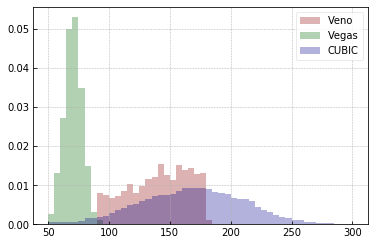

In [6]:
colors = {
    "Veno": "darkred",
    "Vegas": "darkgreen",
    "CUBIC": "darkblue",
     #"reno": "magenta",
}
for protocol_name, timestamps, packets in iter_expression():
    plt.hist(packets, range=(min_amp, max_amp), bins=bins_amp, label=protocol_name, alpha=0.3, density=True, color=colors[protocol_name])
plt.legend()

 T = 198.644
 T_sample = 6.619
Veno 1.0
 T = 0.149
 T_sample = 0.005
Vegas 1.0
 T = 7.336
 T_sample = 0.244
CUBIC 1.0


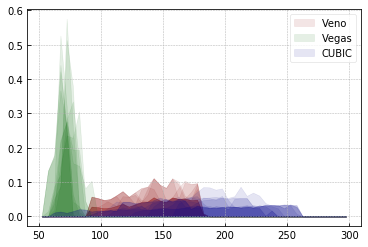

In [7]:
colors = {
    "Veno": "darkred",
    "Vegas": "darkgreen",
    "CUBIC": "darkblue",
     #"reno": "magenta",
}
protocol_pdf = {}
protocol_pdf_bootstrap = {}
protocol_pdf_size = {}
for protocol_name, timestamps, packets in iter_expression():
    M = timestamps.shape[0] // 30
    #T = timestamps.shape[0]
    T = timestamps.shape[0] // 10 * 4
    protocol_pdf_size[protocol_name] = M
    dt = np.diff(timestamps[:2])[0]
    print(" T = {0:.3f}".format(timestamps.shape[0] * dt))
    print(" T_sample = {0:.3f}".format(M * dt))
    mean_scale = 0
    protocol_pdf_bootstrap[protocol_name] = []
    for i in range(500):
        i0 = np.random.randint(0, T - M)
        packets_sample = packets[i0: i0 + M]
        scale, bins_lim = np.histogram(packets_sample, range=(min_amp, max_amp), bins=bins_amp)
        bins_lim = 0.5 * (bins_lim[1:] + bins_lim[:-1])
        scale = scale / scale.sum()
        mean_scale += scale
        protocol_pdf_bootstrap[protocol_name].append(scale)
        if i < 10:
            plt.fill_between(
            bins_lim,
            0,
            scale,
            color=colors[protocol_name],
            alpha=0.1,
            label=protocol_name if i == 0 else None, 
        )
    #mean_scale = mean_scale / 10
    mean_scale = mean_scale/mean_scale.sum()
    protocol_pdf[protocol_name] = mean_scale.copy()
    print(protocol_name, protocol_pdf[protocol_name].sum())

plt.legend()


In [8]:
def _ks(a, b, x, y):
    cr = np.max(np.abs(x.cumsum() - y.cumsum()))
    log_p_value = (-2 * cr ** 2 * ((a * b) / (a + b)))
    return log_p_value

protocols = list(data_packets.keys())


In [9]:
#np.repeat(histogram_range, 2)
#histogram_range, 0.9 * (histogram_range[1] - histogram_range[0])

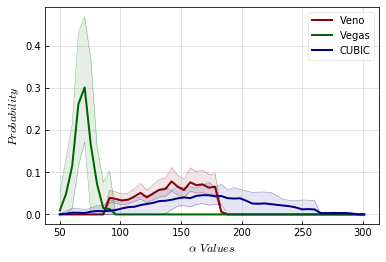

In [10]:
for protocol_name in protocols:
    histogram_range = np.linspace(min_amp, max_amp + 1, bins_amp)
    mean_histogram = np.mean(protocol_pdf_bootstrap[protocol_name], axis=0)
    alpha = 10
    min_histogram = np.percentile(protocol_pdf_bootstrap[protocol_name], alpha, axis=0)
    max_histogram = np.percentile(protocol_pdf_bootstrap[protocol_name], 100 - alpha, axis=0)
    #histogram_range = np.repeat(histogram_range, 2)
    #histogram_range[::2] -= 0.9 * (histogram_range[2] - histogram_range[0])
    #min_histogram = np.repeat(min_histogram, 2)
    #max_histogram = np.repeat(max_histogram, 2)
    #mean_histogram = np.repeat(mean_histogram, 2)
    #plt.gca().set_facecolor("white")
    
    plt.fill_between(histogram_range, min_histogram, max_histogram, color=colors[protocol_name], alpha=0.1)
    plt.plot(histogram_range, mean_histogram, color=colors[protocol_name], label=protocol_name)
    plt.plot(histogram_range, min_histogram, color=colors[protocol_name], linewidth=0.2)
    plt.plot(histogram_range, max_histogram, color=colors[protocol_name], linewidth=0.2)
    #plt.xlabel("$Alpha \ Values$")
    plt.xlabel(r'$\alpha \ Values$')
    plt.ylabel("$Probability$")
   
    #plt.grid(False)
plt.legend()
plt.savefig('probability.svg', format='svg')
None

sampling time [secs]: 3.972461215000007
   Veno -19.804344701211054
   Vegas -1073.8422257883003
   CUBIC -221.08270706292427


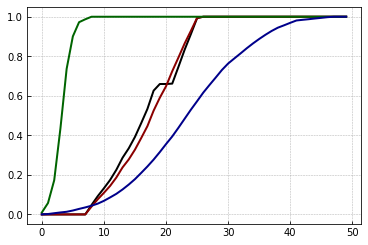

sampling time [secs]: 0.0029683499999926255
   Veno -856.7222042139384
   Vegas -35.07256298586816
   CUBIC -663.7522073452166


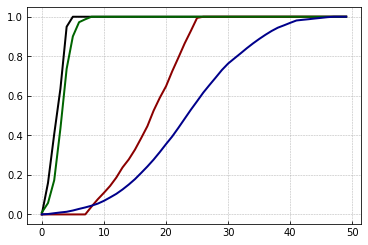

sampling time [secs]: 0.14669604800000347
   Veno -302.7853054179053
   Vegas -727.5003357958361
   CUBIC -12.586481117240554


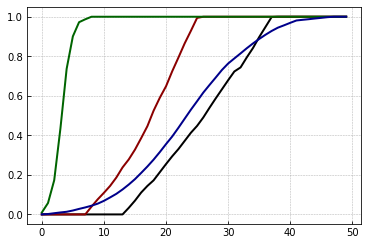

In [11]:
for protocol_name, timestamps, packets in iter_expression():
    M = timestamps.shape[0] // 50
    dt = np.diff(timestamps[:2])[0]
    print("sampling time [secs]:", M * dt)
    T = timestamps.shape[0] // 10 * 7
    i0 = np.random.randint(T, timestamps.shape[0] - M)
    packets_sample = packets[i0: i0 + M]
    scale, bins_lim = np.histogram(packets_sample, range=(min_amp, max_amp), bins=bins_amp)
    bins_lim = 0.5 * (bins_lim[1:] + bins_lim[:-1])
    scale = scale / scale.sum()
    for protocol_name1, _, _ in iter_expression():
        print("  ", protocol_name1, _ks(protocol_pdf_size[protocol_name1], M, scale, protocol_pdf[protocol_name1]))
    plt.plot(scale.cumsum(), color="black")
    for protocol_name1, _, _ in iter_expression():
        plt.plot(protocol_pdf[protocol_name1].cumsum(), color=colors[protocol_name1])
    plt.show()


In [12]:
def _ks2(a, b, x, y):
    cr = np.max(np.abs(x.cumsum() - y.cumsum()))
    p_value = np.exp(-2 * cr ** 2 * ((a * b) / (a + b)))
    return p_value

confusion_matrix_m = np.zeros((len(protocols), len(protocols)))
confusion_matrix_k = np.zeros((len(protocols), len(protocols)))

for protocol_name, timestamps, packets in iter_expression():
    M = timestamps.shape[0] // 30
    dt = np.diff(timestamps[:2])[0]
    T = timestamps.shape[0] // 10 * 7
    for i in range(100):
        i0 = np.random.randint(T, timestamps.shape[0] - M)
        packets_sample = packets[i0: i0 + M]
        scale, bins_lim = np.histogram(packets_sample, range=(min_amp, max_amp), bins=bins_amp)
        bins_lim = 0.5 * (bins_lim[1:] + bins_lim[:-1])
        scale = scale / scale.sum()
        #Log p-value of KS test
        protk = protocols[np.argmax([_ks(protocol_pdf_size[protocol_name1], M, scale, protocol_pdf[protocol_name1]) for protocol_name1 in protocols])]
        print(protocol_name, " => ", "{{{0}}}".format(protk),
              np.max([_ks(protocol_pdf_size[protocol_name1], M, scale, protocol_pdf[protocol_name1]) for protocol_name1 in protocols]),
              np.round([_ks(protocol_pdf_size[protocol_name1], M, scale, protocol_pdf[protocol_name1]) for protocol_name1 in protocols], 3),
        )
        max_difference = lambda protocol_name1: np.max(np.abs(protocol_pdf_bootstrap[protocol_name1] - scale), axis=1)
        protm = protocols[np.argmax([1 - max_difference(protocol_name1).mean() + 2 * max_difference(protocol_name1).std() for protocol_name1 in protocols])]
        print("  *", "{{{0}}}".format(protm), end=":")
        for protocol_name1 in protocols:
            # Complement of the maximum porcentual difference between the statistical behaviour of the protocol and the sample
            print("  [{0}: {1:.2f} +- {2:.2f} ]".format(protocol_name1 , 100 - max_difference(protocol_name1).mean() * 100, max_difference(protocol_name1).std() * 100), end="")
        print()
        confusion_matrix_m[protocols.index(protocol_name)][protocols.index(protm)] += 1
        confusion_matrix_k[protocols.index(protocol_name)][protocols.index(protk)] += 1
            
    #break

Veno  =>  {Veno} -28.949268711007637 [  -28.949 -1252.7    -262.09 ]
  * {Veno}:  [Veno: 95.03 +- 1.07 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 92.96 +- 1.14 ]
Veno  =>  {Veno} -22.3205441135747 [  -22.321 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.14 +- 1.30 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 92.18 +- 1.69 ]
Veno  =>  {Veno} -59.06221069000367 [  -59.062 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.04 +- 1.24 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 92.25 +- 1.52 ]
Veno  =>  {Veno} -57.06953337378426 [  -57.07  -1252.7    -267.472]
  * {Veno}:  [Veno: 94.97 +- 1.21 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 92.25 +- 1.52 ]
Veno  =>  {Veno} -59.00159956592817 [  -59.002 -1252.7    -266.981]
  * {Veno}:  [Veno: 95.20 +- 1.31 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 93.65 +- 1.44 ]
Veno  =>  {Veno} -30.59599339712137 [  -30.596 -1252.7    -267.472]
  * {Veno}:  [Veno: 94.99 +- 1.22 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 91.92 +- 1.66 ]
Veno  =>  {Veno} -39.21439925476429 [  -39.214 -1252.7    -267.472]
  * {Ven

  * {Veno}:  [Veno: 95.12 +- 1.23 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 93.65 +- 1.30 ]
Veno  =>  {Veno} -31.265937177751475 [  -31.266 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.02 +- 1.30 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 91.88 +- 1.63 ]
Veno  =>  {Veno} -28.03386504239557 [  -28.034 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.01 +- 1.17 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 91.91 +- 1.64 ]
Veno  =>  {Veno} -79.24203265499848 [  -79.242 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.01 +- 0.87 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 93.73 +- 1.25 ]
Veno  =>  {Veno} -52.77849473201125 [  -52.778 -1252.7    -262.09 ]
  * {Veno}:  [Veno: 95.20 +- 1.31 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 93.39 +- 1.12 ]
Veno  =>  {Veno} -36.40864500350076 [  -36.409 -1252.7    -266.981]
  * {Veno}:  [Veno: 95.11 +- 1.27 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 92.10 +- 1.60 ]
Veno  =>  {Veno} -59.304966349280946 [  -59.305 -1252.7    -267.472]
  * {Veno}:  [Veno: 95.18 +- 1.27 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 93.6

  * {Vegas}:  [Veno: 65.69 +- 0.00 ]  [Vegas: 81.33 +- 5.56 ]  [CUBIC: 66.08 +- 0.73 ]
Vegas  =>  {Vegas} -105.0875262543756 [-1285.5    -105.088  -907.945]
  * {Vegas}:  [Veno: 50.88 +- 0.00 ]  [Vegas: 74.53 +- 10.00 ]  [CUBIC: 51.26 +- 0.73 ]
Vegas  =>  {Vegas} -261.8847987351222 [-1285.5    -261.885  -907.945]
  * {Vegas}:  [Veno: 64.76 +- 0.00 ]  [Vegas: 69.66 +- 6.98 ]  [CUBIC: 65.17 +- 0.84 ]
Vegas  =>  {Vegas} -193.38437572928802 [-1285.5    -193.384  -893.009]
  * {Vegas}:  [Veno: 54.84 +- 0.00 ]  [Vegas: 64.68 +- 8.92 ]  [CUBIC: 55.25 +- 0.84 ]
Vegas  =>  {Vegas} -102.99697782963835 [-1285.5    -102.997  -879.229]
  * {Vegas}:  [Veno: 68.26 +- 0.00 ]  [Vegas: 70.52 +- 9.59 ]  [CUBIC: 68.91 +- 1.33 ]
Vegas  =>  {Vegas} -102.99697782963835 [-1285.5    -102.997  -879.229]
  * {Vegas}:  [Veno: 68.26 +- 0.00 ]  [Vegas: 72.81 +- 9.90 ]  [CUBIC: 68.91 +- 1.33 ]
Vegas  =>  {Vegas} -33.28729288214698 [-1285.5     -33.287  -907.945]
  * {Vegas}:  [Veno: 51.81 +- 0.00 ]  [Vegas: 74.98 +-

  * {CUBIC}:  [Veno: 91.93 +- 0.94 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 94.91 +- 1.34 ]
CUBIC  =>  {CUBIC} -26.341054541100476 [-451.346 -944.943  -26.341]
  * {CUBIC}:  [Veno: 91.86 +- 0.59 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 94.50 +- 1.32 ]
CUBIC  =>  {CUBIC} -28.982366374668942 [-149.201 -908.473  -28.982]
  * {CUBIC}:  [Veno: 93.11 +- 0.70 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 95.01 +- 1.23 ]
CUBIC  =>  {CUBIC} -52.32541631386347 [-581.201 -944.943  -52.325]
  * {CUBIC}:  [Veno: 91.27 +- 0.23 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 94.20 +- 1.51 ]
CUBIC  =>  {CUBIC} -49.550896114532996 [ -70.513 -908.473  -49.551]
  * {CUBIC}:  [Veno: 94.24 +- 0.91 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 95.28 +- 1.33 ]
CUBIC  =>  {CUBIC} -38.959494198291544 [-519.231 -944.943  -38.959]
  * {CUBIC}:  [Veno: 92.26 +- 1.33 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 95.22 +- 1.26 ]
CUBIC  =>  {CUBIC} -44.943673115283545 [-489.555 -944.943  -44.944]
  * {CUBIC}:  [Veno: 92.33 +- 0.91 ]  [Vegas: 62.41 +- 9.19 ]  [CUBIC: 

In [13]:
print(confusion_matrix_m)
print(confusion_matrix_k)

[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]
[[100.   0.   0.]
 [  0. 100.   0.]
 [  4.   0.  96.]]
